This will detail an AI model to utilise old combine stats from drafted prospects to help predict the performance and likelihood of a current draft prospect.

Exploratory: individual combine factors contribute most to WR/RB getting drafted
Build a model that predicts if a RB/WR gets drafted


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Library Imports**

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [7]:
df = pd.read_csv('/content/drive/MyDrive/Battle of The Brains/tech/NFL_combine.csv')

In [8]:
df.head()

,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,Yes
1,2009,Will Davis\DaviWi99,22.0,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,Arizona Cardinals / 6th / 204th pick / 2009,33.510073,defense,defensive_lineman,DE,Yes
2,2009,Herman Johnson\JohnHe23,24.0,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,Arizona Cardinals / 5th / 167th pick / 2009,41.005821,offense,offensive_lineman,OG,Yes
3,2009,Rashad Johnson\JohnRa98,23.0,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,Arizona Cardinals / 3rd / 95th pick / 2009,28.312463,defense,defensive_back,FS,Yes
4,2009,Cody Brown\BrowCo96,22.0,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,Arizona Cardinals / 2nd / 63rd pick / 2009,31.327425,defense,line_backer,OLB,Yes


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 3477 non-null   int64  
 1   Player               3477 non-null   object 
 2   Age                  2927 non-null   float64
 3   School               3477 non-null   object 
 4   Height               3477 non-null   float64
 5   Weight               3477 non-null   float64
 6   Sprint_40yd          3303 non-null   float64
 7   Vertical_Jump        2780 non-null   float64
 8   Bench_Press_Reps     2572 non-null   float64
 9   Broad_Jump           2749 non-null   float64
 10  Agility_3cone        2260 non-null   float64
 11  Shuttle              2337 non-null   float64
 12  Drafted..tm.rnd.yr.  2254 non-null   object 
 13  BMI                  3477 non-null   float64
 14  Player_Type          3477 non-null   object 
 15  Position_Type        3477 non-null   o

In [10]:
dfclean = df[df["Position_Type"] == "backs_receivers"]

In [11]:
dfclean["Drafted"].replace("Yes", 1, inplace = True)
dfclean["Drafted"].replace("No", 0, inplace = True)
dfclean

<ipython-input-11-95faf81a6851>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfclean["Drafted"].replace("Yes", 1, inplace = True)
<ipython-input-11-95faf81a6851>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfclean["Drafted"].replace("No", 0, inplace = True)


,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,1
13,2009,Davon Drew\DrewDa00,23.0,East Carolina,1.9304,116.119647,4.78,74.93,17.0,287.02,7.28,4.56,Baltimore Ravens / 5th / 149th pick / 2009,31.160979,offense,backs_receivers,TE,1
17,2009,Cedric Peerman\PeerCe00,22.0,Virginia,1.7526,97.975952,4.34,101.60,27.0,297.18,6.99,4.29,Baltimore Ravens / 6th / 185th pick / 2009,31.897297,offense,backs_receivers,RB,1
19,2009,Shawn Nelson\NelsSh00,23.0,Southern Miss,1.9558,108.862169,4.52,83.82,19.0,292.10,6.96,4.46,Buffalo Bills / 4th / 121st pick / 2009,28.459555,offense,backs_receivers,TE,1
26,2009,Tony Fiammetta\FiamTo00,22.0,Syracuse,1.8288,111.130131,4.58,86.36,30.0,284.48,7.31,4.49,Carolina Panthers / 4th / 128th pick / 2009,33.227633,offense,backs_receivers,FB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,2019,Alex Wesley,NaN,Northern Colorado,1.8288,86.182550,4.45,97.79,13.0,317.50,7.40,4.44,NaN,25.768368,offense,backs_receivers,WR,0
3462,2019,Easton Stick,NaN,North Dakota St.,1.8542,101.604691,4.62,85.09,NaN,299.72,6.65,4.05,NaN,29.552934,offense,backs_receivers,QB,0
3463,2019,Benny Snell,NaN,Kentucky,1.7780,101.604691,4.66,74.93,16.0,302.26,7.07,4.33,NaN,32.140324,offense,backs_receivers,RB,0
3470,2019,Ashton Dulin,NaN,Malone University (Ohio),1.8542,97.522360,4.43,96.52,13.0,307.34,7.00,4.22,NaN,28.365539,offense,backs_receivers,WR,0


In [12]:
dfclean = dfclean.drop(["Drafted..tm.rnd.yr.", "Player_Type", "Position_Type"], axis = 1)
dfclean = dfclean[dfclean["Position"] != "QB"]

dfclean

,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,31.004194,RB,1
13,2009,Davon Drew\DrewDa00,23.0,East Carolina,1.9304,116.119647,4.78,74.93,17.0,287.02,7.28,4.56,31.160979,TE,1
17,2009,Cedric Peerman\PeerCe00,22.0,Virginia,1.7526,97.975952,4.34,101.60,27.0,297.18,6.99,4.29,31.897297,RB,1
19,2009,Shawn Nelson\NelsSh00,23.0,Southern Miss,1.9558,108.862169,4.52,83.82,19.0,292.10,6.96,4.46,28.459555,TE,1
26,2009,Tony Fiammetta\FiamTo00,22.0,Syracuse,1.8288,111.130131,4.58,86.36,30.0,284.48,7.31,4.49,33.227633,FB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,2019,Alex Barnes\BarnAl01,NaN,Kansas St.,1.8288,102.511876,4.59,97.79,34.0,320.04,6.95,4.10,30.650796,RB,0
3459,2019,Alex Wesley,NaN,Northern Colorado,1.8288,86.182550,4.45,97.79,13.0,317.50,7.40,4.44,25.768368,WR,0
3463,2019,Benny Snell,NaN,Kentucky,1.7780,101.604691,4.66,74.93,16.0,302.26,7.07,4.33,32.140324,RB,0
3470,2019,Ashton Dulin,NaN,Malone University (Ohio),1.8542,97.522360,4.43,96.52,13.0,307.34,7.00,4.22,28.365539,WR,0


array([[<Axes: title={'center': 'Age'}>]], dtype=object)

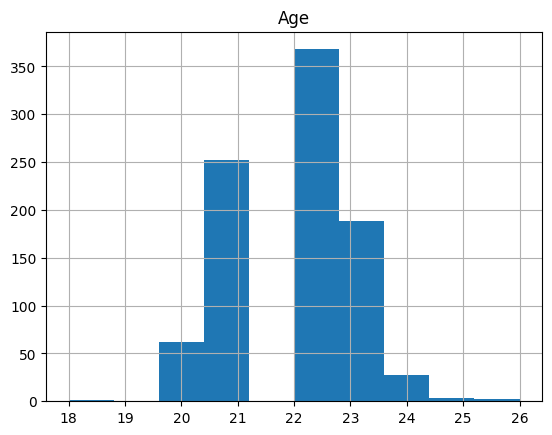

In [13]:
dfclean.hist("Age")

In [14]:
dfclean.mode

<bound method DataFrame.mode of       Year                   Player   Age                    School  Height  \
0     2009    Beanie Wells\WellCh00  20.0                  Ohio St.  1.8542   
13    2009      Davon Drew\DrewDa00  23.0             East Carolina  1.9304   
17    2009  Cedric Peerman\PeerCe00  22.0                  Virginia  1.7526   
19    2009    Shawn Nelson\NelsSh00  23.0             Southern Miss  1.9558   
26    2009  Tony Fiammetta\FiamTo00  22.0                  Syracuse  1.8288   
...    ...                      ...   ...                       ...     ...   
3456  2019     Alex Barnes\BarnAl01   NaN                Kansas St.  1.8288   
3459  2019              Alex Wesley   NaN         Northern Colorado  1.8288   
3463  2019              Benny Snell   NaN                  Kentucky  1.7780   
3470  2019             Ashton Dulin   NaN  Malone University (Ohio)  1.8542   
3471  2019              Keelan Doss   NaN                  UC Davis  1.8796   

          Weight  Sprint_40yd  Vertical_Jump  Bench_Press_Reps  Broad_Jump  \
0     106.594207         4.38          85.09              25.0      325.12   
13    116.119647         4.78          74.93              17.0      287.02   
17     97.975952         4.34         101.60              27.0      297.18   
19    108.862169         4.52          83.82              19.0      292.10   
26    111.130131         4.58          86.36              30.0      284.48   
...          ...          ...            ...               ...         ...   
3456  102.511876         4.59          97.79              34.0      320.04   
3459   86.182550         4.45          97.79              13.0      317.50   
3463  101.604691         4.66          74.93              16.0      302.26   
3470   97.522360         4.43          96.52              13.0      307.34   
3471   95.707990          NaN            NaN               8.0         NaN   

      Agility_3cone  Shuttle        BMI Position  Drafted  
0               NaN      NaN  31.004194       RB        1  
13             7.28     4.56  31.160979       TE        1  
17             6.99     4.29  31.897297       RB        1  
19             6.96     4.46  28.459555       TE        1  
26             7.31     4.49  33.227633       FB        1  
...             ...      ...        ...      ...      ...  
3456           6.95     4.10  30.650796       RB        0  
3459           7.40     4.44  25.768368       WR        0  
3463           7.07     4.33  32.140324       RB        0  
3470           7.00     4.22  28.365539       WR        0  
3471            NaN      NaN  27.090519       WR        0  

[1066 rows x 15 columns]>

In [15]:
dfclean["Age"] = dfclean["Age"].fillna(22)

In [16]:
dfclean

,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,31.004194,RB,1
13,2009,Davon Drew\DrewDa00,23.0,East Carolina,1.9304,116.119647,4.78,74.93,17.0,287.02,7.28,4.56,31.160979,TE,1
17,2009,Cedric Peerman\PeerCe00,22.0,Virginia,1.7526,97.975952,4.34,101.60,27.0,297.18,6.99,4.29,31.897297,RB,1
19,2009,Shawn Nelson\NelsSh00,23.0,Southern Miss,1.9558,108.862169,4.52,83.82,19.0,292.10,6.96,4.46,28.459555,TE,1
26,2009,Tony Fiammetta\FiamTo00,22.0,Syracuse,1.8288,111.130131,4.58,86.36,30.0,284.48,7.31,4.49,33.227633,FB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,2019,Alex Barnes\BarnAl01,22.0,Kansas St.,1.8288,102.511876,4.59,97.79,34.0,320.04,6.95,4.10,30.650796,RB,0
3459,2019,Alex Wesley,22.0,Northern Colorado,1.8288,86.182550,4.45,97.79,13.0,317.50,7.40,4.44,25.768368,WR,0
3463,2019,Benny Snell,22.0,Kentucky,1.7780,101.604691,4.66,74.93,16.0,302.26,7.07,4.33,32.140324,RB,0
3470,2019,Ashton Dulin,22.0,Malone University (Ohio),1.8542,97.522360,4.43,96.52,13.0,307.34,7.00,4.22,28.365539,WR,0


In [17]:
y = dfclean["Drafted"]
X = dfclean[["Age"]]
X = sm.add_constant(X)
model1 = sm.Logit(y, X).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.656511
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1064
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                 0.01659
Time:                        08:04:58   Log-Likelihood:                -699.84
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 1.181e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0744      1.604      5.034      0.000       4.930      11.218
Age           -0.3475      0.

In [18]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height"]]
X = sm.add_constant(X)
model2 = sm.Logit(y, X).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.655232
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1063
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                 0.01850
Time:                        08:04:58   Log-Likelihood:                -698.48
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 1.911e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5463      2.214      2.505      0.012       1.207       9.885
Age           -0.3582      0.

In [19]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight"]]
X = sm.add_constant(X)
model3 = sm.Logit(y, X).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.653677
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1062
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                 0.02083
Time:                        08:04:58   Log-Likelihood:                -696.82
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 1.634e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8104      2.328      2.925      0.003       2.247      11.374
Age           -0.3608      0.

In [20]:
dfclean.describe()

,Year,Age,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,BMI,Drafted
count,1066.000000,1066.000000,1066.000000,1066.000000,1013.000000,894.000000,853.000000,869.000000,682.000000,711.000000,1066.000000,1066.000000
mean,2014.022514,21.886492,1.846146,98.309976,4.573633,88.060436,17.372802,302.637054,7.019589,4.282377,28.817718,0.612570
std,3.153575,0.897187,0.070535,10.458313,0.145957,8.043006,5.243311,15.213116,0.221200,0.156751,2.303876,0.487392
min,2009.000000,18.000000,1.651000,67.585263,4.220000,67.310000,3.000000,259.080000,6.420000,3.810000,22.315242,0.000000
25%,2011.000000,21.000000,1.803400,90.718474,4.480000,82.550000,14.000000,292.100000,6.870000,4.180000,26.997872,0.000000
50%,2014.000000,22.000000,1.828800,96.615175,4.550000,87.630000,17.000000,302.260000,7.010000,4.280000,28.880210,1.000000
75%,2017.000000,22.000000,1.905000,104.779837,4.650000,92.710000,21.000000,312.420000,7.150000,4.390000,30.559595,1.000000
max,2019.000000,26.000000,2.032000,126.098679,5.060000,114.300000,36.000000,358.140000,7.680000,4.750000,37.796440,1.000000


<Axes: >

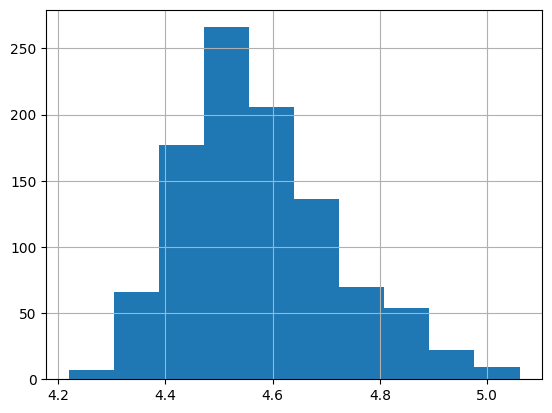

In [21]:
dfclean["Sprint_40yd"].hist()


<Axes: >

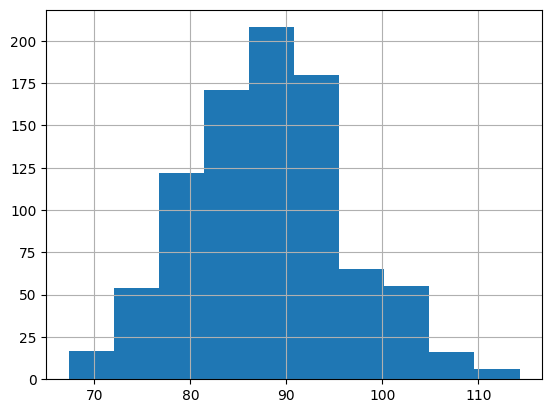

In [22]:
dfclean["Vertical_Jump"].hist()


In [23]:
dfclean["Sprint_40yd"] = dfclean["Sprint_40yd"].fillna(dfclean["Sprint_40yd"].mean())
dfclean["Vertical_Jump"] = dfclean["Vertical_Jump"].fillna(dfclean["Vertical_Jump"].mean())
dfclean["Bench_Press_Reps"] = dfclean["Bench_Press_Reps"].fillna(dfclean["Bench_Press_Reps"].mean())
dfclean["Broad_Jump"] = dfclean["Broad_Jump"].fillna(dfclean["Broad_Jump"].mean())
dfclean["Agility_3cone"] = dfclean["Agility_3cone"].fillna(dfclean["Agility_3cone"].mean())
dfclean["Shuttle"] = dfclean["Shuttle"].fillna(dfclean["Shuttle"].mean())

In [24]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd"]]
X = sm.add_constant(X)
model4 = sm.Logit(y, X).fit()
print(model4.summary())

Optimization terminated successfully.
         Current function value: 0.599230
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1061
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1024
Time:                        08:04:59   Log-Likelihood:                -638.78
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 1.673e-30
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          33.3170      3.642      9.149      0.000      26.180      40.454
Age            -0.3406    

In [25]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump"]]
X = sm.add_constant(X)
model5 = sm.Logit(y, X).fit()
print(model5.summary())

Optimization terminated successfully.
         Current function value: 0.599068
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1060
Method:                           MLE   Df Model:                            5
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1026
Time:                        08:04:59   Log-Likelihood:                -638.61
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 9.131e-30
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            32.1864      4.109      7.832      0.000      24.132      40.241
Age              -0.

In [26]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps"]]
X = sm.add_constant(X)
model6 = sm.Logit(y, X).fit()
print(model6.summary())

Optimization terminated successfully.
         Current function value: 0.598288
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1059
Method:                           MLE   Df Model:                            6
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1038
Time:                        08:04:59   Log-Likelihood:                -637.77
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 2.323e-29
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               31.1628      4.183      7.449      0.000      22.964      39.362
Age        

In [27]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Broad_Jump"]]
X = sm.add_constant(X)
model7 = sm.Logit(y, X).fit()
print(model7.summary())

Optimization terminated successfully.
         Current function value: 0.597335
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1058
Method:                           MLE   Df Model:                            7
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1052
Time:                        08:05:00   Log-Likelihood:                -636.76
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 4.533e-29
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               28.2825      4.632      6.105      0.000      19.203      37.362
Age        

In [28]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Broad_Jump", "Agility_3cone"]]
X = sm.add_constant(X)
model8 = sm.Logit(y, X).fit()
print(model8.summary())

Optimization terminated successfully.
         Current function value: 0.593717
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1057
Method:                           MLE   Df Model:                            8
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1106
Time:                        08:05:00   Log-Likelihood:                -632.90
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 5.367e-30
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               36.5959      5.579      6.560      0.000      25.661      47.531
Age        

In [29]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Broad_Jump", "Agility_3cone", "Shuttle"]]
X = sm.add_constant(X)
model9 = sm.Logit(y, X).fit()
print(model9.summary())

Optimization terminated successfully.
         Current function value: 0.593427
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1056
Method:                           MLE   Df Model:                            9
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1111
Time:                        08:05:00   Log-Likelihood:                -632.59
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 1.840e-29
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               37.5114      5.709      6.571      0.000      26.322      48.700
Age        

In [30]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Broad_Jump", "Agility_3cone", "Shuttle", "BMI"]]
X = sm.add_constant(X)
model10 = sm.Logit(y, X).fit()
print(model10.summary())


Optimization terminated successfully.
         Current function value: 0.581198
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Drafted   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1055
Method:                           MLE   Df Model:                           10
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1294
Time:                        08:05:00   Log-Likelihood:                -619.56
converged:                       True   LL-Null:                       -711.65
Covariance Type:            nonrobust   LLR p-value:                 3.180e-34
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              167.5379     27.101      6.182      0.000     114.421     220.655
Age        

<Axes: >

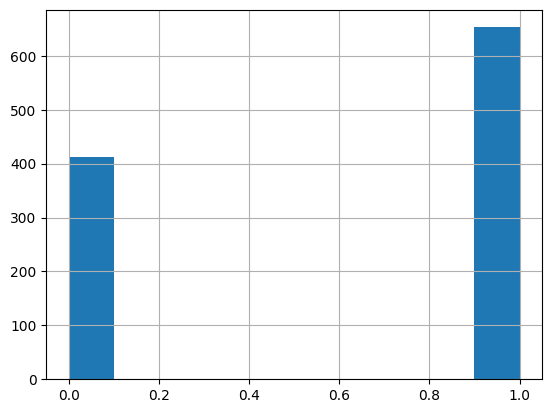

In [31]:
#Final answer - 40 yard sprint seems to be the most significant in explaining whether a back/receiver gets drafted
dfclean["Drafted"].hist()
#Slight imbalance in outcome

In [32]:
#Baseline model
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Broad_Jump", "Agility_3cone", "Shuttle", "BMI"]]
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)
rfbase = RandomForestClassifier(random_state=0)
rfbase.fit(X_train,y_train)
y_pred = rfbase.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[ 38  48]
 [ 27 101]]
              precision    recall  f1-score   support

           0       0.58      0.44      0.50        86
           1       0.68      0.79      0.73       128

    accuracy                           0.65       214
   macro avg       0.63      0.62      0.62       214
weighted avg       0.64      0.65      0.64       214



In [36]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Broad_Jump", "Agility_3cone", "Shuttle", "BMI"]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

param_grid = [{'max_depth': [2, 4, 6, 8, 10, 16, 20], 'n_estimators': [5, 10, 20, 50, 100]}]

rfc = RandomForestClassifier(random_state = 0)

grid_search = GridSearchCV(rfc, param_grid, cv=3)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [37]:
y = dfclean["Drafted"]
X = dfclean[["Age", "Height", "Weight", "Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Broad_Jump", "Agility_3cone", "Shuttle", "BMI"]]
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)
rfbase = RandomForestClassifier(max_depth = 4, n_estimators = 100, random_state=0)
rfbase.fit(X_train,y_train)
y_pred = rfbase.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[ 25  61]
 [ 17 111]]
              precision    recall  f1-score   support

           0       0.60      0.29      0.39        86
           1       0.65      0.87      0.74       128

    accuracy                           0.64       214
   macro avg       0.62      0.58      0.57       214
weighted avg       0.63      0.64      0.60       214

